In [43]:
import os
os.chdir('..')
print(os.getcwd())

/Users/alex.shtoff/git


In [44]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import entr
import pandas as pd
from exp_prox.np import prox_op

In [45]:
def generate_data(m, n):
    # for reproducibility - random seed
    np.random.seed(2024)

    # define function parameters - use long-tailed distributions to get both small and large values
    thetas = np.random.standard_cauchy(size=(m, n))
    phis = np.random.standard_cauchy(size=(m, n))
    bs = np.random.standard_cauchy(size=m)
    alphas = np.random.lognormal(size=m, mean=-3, sigma=2)

    # define prox operator argument and step-sizes
    ws = np.random.standard_cauchy(size=(m, n))
    etas = np.random.lognormal(size=m, mean=-3, sigma=2)

    return ws, etas, thetas, phis, bs, alphas

In [46]:
m = 5000
n = 50
ws, etas, thetas, phis, bs, alphas = generate_data(m, n)

In [47]:
percentiles = [
    np.percentile(z.ravel(), q=[0.1, 1, 25, 50, 75, 99, 99.9])
    for z in [ws, etas, thetas, phis, bs, alphas]
]
percentile_df = pd.DataFrame(percentiles,
             columns=pd.Index(['P-0.1\\%', 'P-1\\%', 'P-25\\%', 'P-50\\%', 'P-75\\%', 'P-99\\%', 'P-99.9\\%'], name='Percentile'),
             index=pd.Index(['$\\vw$', '$\\eta$', '$\\vtheta$', '$\\vphi$', '$b$', '$\\alpha$'], name='Vector'))
print(percentile_df.to_latex(float_format="%.3g"))

\begin{tabular}{lrrrrrrr}
\toprule
Percentile & P-0.1\% & P-1\% & P-25\% & P-50\% & P-75\% & P-99\% & P-99.9\% \\
Vector &  &  &  &  &  &  &  \\
\midrule
$\vw$ & -294 & -31.5 & -0.992 & 0.00366 & 1 & 32.2 & 347 \\
$\eta$ & 0.000116 & 0.000468 & 0.0127 & 0.047 & 0.181 & 4.4 & 17.9 \\
$\vtheta$ & -330 & -32.5 & -1.01 & -0.00377 & 0.999 & 32.3 & 334 \\
$\vphi$ & -341 & -32 & -1 & -0.00267 & 0.994 & 32.4 & 329 \\
$b$ & -138 & -26.1 & -0.986 & -0.0112 & 1.04 & 30.5 & 372 \\
$\alpha$ & 0.000126 & 0.000449 & 0.0124 & 0.0487 & 0.191 & 4.01 & 13.9 \\
\bottomrule
\end{tabular}



In [48]:
# compute using CVXPY
w_next_cp = []
for row in range(m):
    u = cp.Variable(n)
    objective = (
        cp.exp(cp.vdot(u, thetas[row]) + bs[row]) +
        cp.vdot(u, phis[row]) +
        alphas[row] * cp.sum_squares(u) / 2 +
        cp.sum_squares(ws[row] - u) / (2 * etas[row])
    )
    prob = cp.Problem(cp.Minimize(objective))
    prob.solve()
    w_next_cp.append(u.value)
w_next_cp = np.stack(w_next_cp)

In [49]:
w_next, duals = prox_op(ws, etas, thetas, phis, bs, alphas, return_dual=True)

In [50]:
plt.style.use('grayscale')
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'xtick.labelsize': 18})

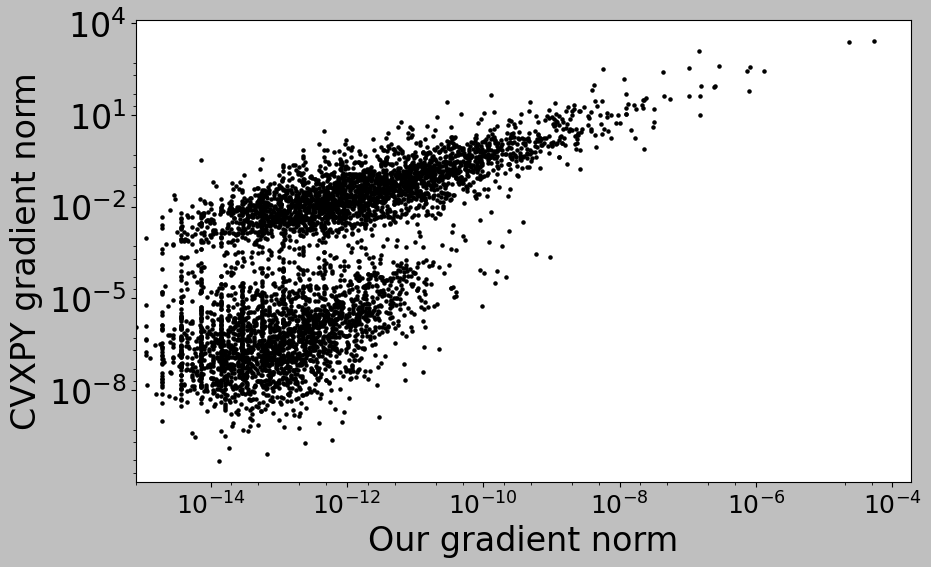

In [51]:
def grad_norms(w_next, ws, etas, thetas, phis, bs, alphas):
    alphas_loc = alphas.reshape(-1, 1)
    etas_loc = etas.reshape(-1, 1)

    exp_arg = np.sum(thetas * w_next, axis=1) + bs
    exp_part = np.exp(exp_arg).reshape(-1, 1)

    grad = thetas * exp_part + phis + alphas_loc * w_next + (w_next - ws) / etas_loc
    return np.max(np.abs(grad), axis=1)

nrm_func = lambda w: grad_norms(w, ws, etas, thetas, phis, bs, alphas)
plt.figure(figsize=(10, 6))
plt.scatter(nrm_func(w_next), nrm_func(w_next_cp), s=5)
plt.xscale('asinh', linear_width=1e-15)
plt.yscale('asinh', linear_width=1e-15)
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=7))
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=7))
plt.xlabel('Our gradient norm')
plt.ylabel('CVXPY gradient norm')
plt.show()

In [52]:
def duality_gaps(duals, w_next, ws, etas, thetas, phis, bs, alphas):
    alphas = alphas.reshape(-1, 1)
    etas = etas.reshape(-1, 1)

    def menv(ys):
        vals = (alphas * np.square(ys) - etas * np.square(phis) + 2 * ys * phis) / (2 * alphas * etas + 2)
        return np.sum(vals, axis=1)


    primal_obj = np.exp(np.sum(thetas * w_next, axis=-1) + bs) + np.sum(
        phis * w_next +
        alphas * np.square(w_next) / 2 +
        np.square(ws - w_next) / (2 * etas), axis=-1)

    dual_obj = (
        menv(ws - etas * duals * thetas) +
        (np.sum(thetas * ws, axis=-1) + bs) * duals.ravel() -
        np.sum(etas * np.square(thetas), axis=-1) * np.square(duals.ravel()) / 2 -
        (-entr(duals) - duals).ravel()
    )

    return np.clip(primal_obj - dual_obj, a_min=0, a_max=np.inf)

In [53]:
dims = [10, 20, 50, 100, 500, 1000, 10000, 100000]
mean_norms = []
high_pctile_norms = []
max_norms = []
mean_gaps = []
high_pctile_gaps = []
max_gaps = []
for dim in dims:
    ws, etas, thetas, phis, bs, alphas = generate_data(m, dim)
    w_next, duals = prox_op(ws, etas, thetas, phis, bs, alphas, return_dual=True)

    norms = grad_norms(w_next, ws, etas, thetas, phis, bs, alphas)
    mean_norms.append(np.mean(norms))
    high_pctile_norms.append(np.percentile(norms, q=95))
    max_norms.append(np.max(norms))

    gaps = duality_gaps(duals, w_next, ws, etas, thetas, phis, bs, alphas)
    mean_gaps.append(np.mean(gaps))
    high_pctile_gaps.append(np.percentile(gaps, q=95))
    max_gaps.append(np.max(gaps))

In [55]:
import pandas as pd
norms_df = pd.DataFrame({
    'Dimension': dims,
    'Avg. norm': mean_norms,
    'P95 norm': high_pctile_norms,
    'Max. norm': max_norms,
    'Avg. gap': mean_gaps,
    'P95 gap': high_pctile_gaps,
    'Max. gap': max_gaps
})
norms_df

,Dimension,Avg. norm,P95 norm,Max. norm,Avg. gap,P95 gap,Max. gap
0,10,1.228181e-10,1.873662e-11,2.183806e-07,6.463731e-12,4.547474e-13,1.490116e-08
1,20,7.109604e-09,4.002914e-11,1.780828e-05,3.463575e-10,9.094947e-13,9.536743e-07
2,50,1.667669e-08,1.629417e-10,5.400181e-05,2.192458e-10,3.683454e-12,7.152557e-07
3,100,1.084203e-08,5.038288e-10,3.649422e-05,8.244370e-10,1.455192e-11,3.814697e-06
4,500,1.374404e-07,4.132187e-09,3.419321e-04,2.656971e-05,2.328306e-10,1.250000e-01
5,1000,3.688620e-07,7.877878e-09,8.648899e-04,6.758065e-08,9.313226e-10,1.220703e-04
6,10000,1.846728e-06,1.549165e-07,2.435025e-03,2.569989e-05,1.192093e-07,1.250000e-01
7,100000,2.927148e-04,2.665751e-06,9.138719e-01,2.180719e-04,1.525879e-05,7.500000e-01


In [12]:
print(norms_df.to_latex(index=False, float_format="%.2e"))

\begin{tabular}{rrrr}
\toprule
Dimension & Avg. norm & P95 norm & Max. norm \\
\midrule
10 & 1.23e-10 & 1.87e-11 & 2.18e-07 \\
20 & 7.11e-09 & 4.00e-11 & 1.78e-05 \\
50 & 1.67e-08 & 1.63e-10 & 5.40e-05 \\
100 & 1.08e-08 & 5.04e-10 & 3.65e-05 \\
500 & 1.37e-07 & 4.13e-09 & 3.42e-04 \\
1000 & 3.69e-07 & 7.88e-09 & 8.65e-04 \\
10000 & 1.85e-06 & 1.55e-07 & 2.44e-03 \\
100000 & 2.93e-04 & 2.67e-06 & 9.14e-01 \\
\bottomrule
\end{tabular}

